In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.autograd as autograd

## Hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
lr = 0.0001
num_workers = 0
img_shape = (1, 32, 32)
g_input_dim = 100
num_epochs = 200
clip_value = 0.01
n_critic= 5

In [3]:
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor()])

In [4]:
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, num_workers= num_workers)

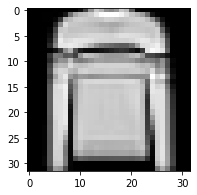

In [5]:
def visualize(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    images = images / 2 + 0.5  
    images = images.numpy()
    
    #get one image in batch
    img = np.squeeze(images[5])
    fig = plt.figure(figsize = (3,3)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

visualize(train_loader)

## Define the model

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, img_size = (1, 32, 32), g_input_dim = 100):
        super(Generator, self).__init__()

        self.input_dim = g_input_dim
        self.img_size = img_size

        self.latent_to_feature = nn.Sequential(
            nn.Linear(g_input_dim, 512),
            nn.ReLU()
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),    #(128, 2, 2) --> (64, 4, 4)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    #(64, 4, 4) --> (32, 8, 8)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),    #(32, 8, 8) --> (16, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, self.img_size[0], 4, 2, 1),    #(16, 16, 16) -->(1, 32, 32)
            nn.Sigmoid()
        )
    def forward(self, z):
        x = self.latent_to_feature(z)
        x = x.view(-1, 128, 2, 2)
        img = self.conv(x)
        return img

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_size = (1, 32, 32)):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.img_size[0], 16, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.Sigmoid(),
        )

        self.features_to_prob = nn.Sequential(
            nn.Linear(512, 1),
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.conv(input_data)
        x = x.view(batch_size, -1)

        return self.features_to_prob(x)

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

print(G)
print(D)

Generator(
  (latent_to_feature): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
  )
  (conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32,

## Define Optimizers

In [9]:
d_optimizer = optim.RMSprop(D.parameters(), lr)
g_optimizer = optim.RMSprop(G.parameters(), lr)

## Training

In [10]:
D.train()
G.train()
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        #TRAIN DISCRIMINATOR
        d_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size= (batch_size, g_input_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)

        d_loss = torch.mean(D(fake_images)) - torch.mean(D(real_images))

        d_loss.backward()
        d_optimizer.step()

        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i%n_critic == 0:
            g_optimizer.zero_grad()

            fake_images = G(z)
            g_loss = -torch.mean(D(fake_images))

            g_loss.backward()
            g_optimizer.step()
    print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, num_epochs, d_loss.item(), g_loss.item()))

[Epoch 0/200] [D loss: -0.037755] [G loss: 0.176545]
[Epoch 1/200] [D loss: -0.013981] [G loss: 0.141477]
[Epoch 2/200] [D loss: -0.006624] [G loss: 0.166096]
[Epoch 3/200] [D loss: -0.008945] [G loss: 0.207028]
[Epoch 4/200] [D loss: -0.006049] [G loss: 0.204304]
[Epoch 5/200] [D loss: -0.001309] [G loss: 0.207180]
[Epoch 6/200] [D loss: -0.001791] [G loss: 0.199621]
[Epoch 7/200] [D loss: -0.002274] [G loss: 0.198584]
[Epoch 8/200] [D loss: -0.003588] [G loss: 0.180034]
[Epoch 9/200] [D loss: -0.001951] [G loss: 0.185056]
[Epoch 10/200] [D loss: -0.001976] [G loss: 0.196174]
[Epoch 11/200] [D loss: -0.002423] [G loss: 0.207464]
[Epoch 12/200] [D loss: 0.000293] [G loss: 0.225406]
[Epoch 13/200] [D loss: -0.001392] [G loss: 0.208159]
[Epoch 14/200] [D loss: -0.001253] [G loss: 0.208836]
[Epoch 15/200] [D loss: -0.001856] [G loss: 0.191370]
[Epoch 16/200] [D loss: 0.000622] [G loss: 0.233016]
[Epoch 17/200] [D loss: -0.002016] [G loss: 0.194521]
[Epoch 18/200] [D loss: -0.001097] [G lo

## Evaluation

In [18]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=10, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32)).to("cpu"), cmap='Greys_r')

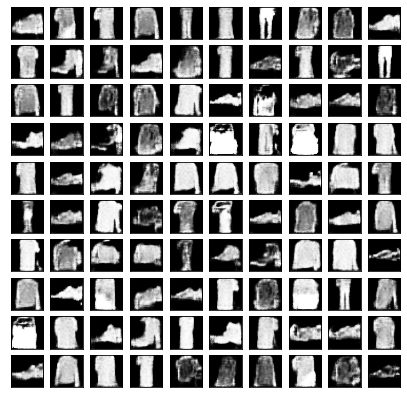

In [19]:
# randomly generated, new latent vectors
sample_size=100
rand_z = np.random.uniform(-1, 1, size=(sample_size, g_input_dim))
rand_z = torch.from_numpy(rand_z).float().to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)
view_samples(0, [rand_images])